## **<span style="color:#023e8a;font-size:200%"><center> 🔥🔥EDA NBME🔥🔥</center></span>**
## **<center><span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 5px">If you find this notebook useful or interesting, please, support with an upvote :)</span></center>**

## **<span style="color:#023e8a;font-size:1000%"><center>EDA</center></span><span style="color:#023e8a;font-size:200%"><center>NLP. MBME</center></span>**

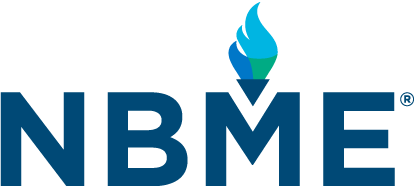

# **<a id="Content" style="color:#023e8a;">Table of Content</a>**
* [**<span style="color:#023e8a;">1. First look 👀</span>**](#First)  
* [**<span style="color:#023e8a;">2. Cloudwords by case</span>**](#Clouds)  
* [**<span style="color:#023e8a;">3. Cloudwords by patient notes</span>**](#Clouds_2)   
* [**<span style="color:#023e8a;">4. Content stat</span>**](#stat)   
* [**<span style="color:#023e8a;">5. Spacy Visualization</span>**](#spacy)   

## **<span style="color:#023e8a;">Intro. Score Clinical Patient Notes</span>**

**<span style="color:#023e8a;"> This competition dedicates to clinical concept identification. Some of which: </span>**

🩺 `Anthropometric data`  

🩺 `Family`  

🩺 `Addictions`  

🩺 `Symptoms`  


**<span style="color:#023e8a;"> Results allow to reveale important information from the notes fast and precise. </span>**

## **<span id="First" style="color:#023e8a;">1. First look 👀</span>**

[**<span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 2px">Go to Table of Content</span>**](#Content)

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
features = pd.read_csv("../input/nbme-score-clinical-patient-notes/features.csv")
patient_notes = pd.read_csv("../input/nbme-score-clinical-patient-notes/patient_notes.csv")
train = pd.read_csv("../input/nbme-score-clinical-patient-notes/train.csv")
test = pd.read_csv("../input/nbme-score-clinical-patient-notes/test.csv")
submission = pd.read_csv("../input/nbme-score-clinical-patient-notes/sample_submission.csv")

### **<span style="color:#023e8a;">Features</span>**

In [ ]:
features.head()

**<span style="color:#023e8a;"> Description: </span>**

> `feature_num` **<span style="color:#023e8a;">: A unique identifier for each feature.</span>**  
> `feature_text` **<span style="color:#023e8a;">: A description of the feature.</span>**  

In [ ]:
print(f'Shape of features:{features.shape}, \n'
      f'With unique num of features: {features.feature_num.nunique()} \n'
      f'num of any missed cell in the df: {features.isna().sum().sum()}')

### **<span style="color:#023e8a;">Patient_notes</span>**

In [ ]:
patient_notes.head()

**<span style="color:#023e8a;"> Some phrases can be written the different way. For example, "years old", "yo" or "y.o.". Just look at the frequency of usage these three types in patient notes. </span>**

**<span style="color:#023e8a;"> Even full years old phrase have 3+ types of writing. Then it needs to be careful when processing, because more important pharases which is helpful for recognition can be written differently. </span>**

In [ ]:
yo = patient_notes[patient_notes['pn_history'].str.contains('yo')].shape[0]
yo_dots = patient_notes[patient_notes['pn_history'].str.contains('y.o.')].shape[0]
yo_fulls = patient_notes[patient_notes['pn_history'].str.contains('year-old')].shape[0] + \
patient_notes[patient_notes['pn_history'].str.contains('years old')].shape[0] + \
patient_notes[patient_notes['pn_history'].str.contains('years-old')].shape[0] + \
patient_notes[patient_notes['pn_history'].str.contains('year old')].shape[0]

print(f'yo: {yo} \ny.o.: {yo_dots} \nyear old: {yo_fulls}')

**<span style="color:#023e8a;"> Description: </span>**

> `pn_num` **<span style="color:#023e8a;">: A unique identifier for each patient note.</span>**  
> `pn_history` **<span style="color:#023e8a;">: A description of the feature.</span>**  

In [ ]:
print(f'Shape of patient_notes:{patient_notes.shape}, \n'
      f'With unique num of patient notes: {patient_notes.pn_num.nunique()} \n'
      f'num of any missed cell in the df: {patient_notes.isna().sum().sum()}')

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df_count = patient_notes.groupby('case_num').count()

f, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(data=df_count, x=df_count.index, y=df_count['pn_num'], palette=sns.color_palette("hls", 8))
plt.xlabel('Case num', fontsize=16)
plt.ylabel('Case count', fontsize=16)
plt.show()

### **<span style="color:#023e8a;">Train</span>**

**<span style="color:#023e8a;"> Just to understand, that every case_num has own feature nums and feature num = concatination of case number and feature num (if < 10 then 0 between)</span>**

In [ ]:
train.head()

In [ ]:
train[train['case_num'] == 1].head()

**<span style="color:#023e8a;"> Description: </span>**

> `id` **<span style="color:#023e8a;">: Unique identifier for each patient note / feature pair.</span>**  
> `case_num` **<span style="color:#023e8a;">: The case to which this patient note belongs.</span>** **<span style="color:#FF0000;">(in </span>**`features` **<span style="color:#FF0000;"> and </span>** `patient_note` **<span style="color:#FF0000;"> tables)</span>**  
> `pn_num` **<span style="color:#023e8a;">: The patient note annotated in this row.</span>** **<span style="color:#FF0000;">(in </span>** `patient_note` **<span style="color:#FF0000;"> table) <span>**  
> `feature_num` **<span style="color:#023e8a;">: The feature annotated in this row.</span>** **<span style="color:#FF0000;">(in </span>** `features` **<span style="color:#FF0000;"> table)</span>**  
> `annotation` **<span style="color:#023e8a;">: The text(s) within a patient note indicating a feature. A feature may be indicated multiple times within a single note.</span>**  
> `location` **<span style="color:#023e8a;">: Character spans indicating the location of each annotation within the note.</span>**  

**<span style="color:#023e8a;"> The same features in</span>** `test` , **<span style="color:#023e8a;">excluding</span>** `annotation`, `location`</span>

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df_count = train.groupby('case_num').count()

f, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(data=df_count, x=df_count.index, y=df_count['id'], palette=sns.color_palette("hls", 8))
plt.xlabel('Case num', fontsize=16)
plt.ylabel('patients count', fontsize=16)
plt.show()

In [ ]:
print(f'Shape of features:{train.shape}, \n'
      f'With unique num of patient notes: {train.pn_num.nunique()}, and cases: {train.case_num.nunique()} \n'
      f'and unique num of annotations: {train.annotation.nunique()} and unique num of features: {train.feature_num.nunique()} \n'
      f'num of any missed cell in the df: {train.isna().sum().sum()}')

### **<span style="color:#023e8a;">Test</span>**

In [ ]:
test.head()

In [ ]:
print(f'Shape of features:{test.shape}, \n'
      f'With unique num of patient notes: {test.pn_num.nunique()}, and cases: {test.case_num.nunique()} \n'
      f'num of any missed cell in the df: {test.isna().sum().sum()}')

### **<span style="color:#023e8a;">Merging  Features and Patient Notes with train and test</span>**

In [ ]:
patient_notes.pn_num.count() - patient_notes.pn_num.nunique()

**<span style="color:#023e8a;">Can merge only by pn_num</span>**

In [ ]:
features.drop('case_num', axis=1, inplace=True)
patient_notes.drop('case_num', axis=1, inplace=True)
train = train.merge(how='left', right=features, on='feature_num', copy=False)
train = train.merge(how='left', right=patient_notes, on='pn_num', copy=False)

In [ ]:
test = test.merge(how='left', right=features, on='feature_num', copy=False)
test = test.merge(how='left', right=patient_notes, on='pn_num', copy=False)

In [ ]:
train.head()

In [ ]:
empt = len(train[train.location == '[]'])
empty_annotations = empt / len(train)
print(f'number of empty annotations in train: {empt} or {empty_annotations:.2%} from train dataset')

## **<span id="Clouds" style="color:#023e8a;">2. Cloudwords by case</span>**

[**<span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 2px">Go to Table of Content</span>**](#Content)

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [ ]:
cloud = WordCloud(background_color="white", max_words=50, stopwords=set(STOPWORDS), width=600, height=250)
f, axs = plt.subplots(5, 2, figsize=(20, 20))
f.suptitle('WordCloud by case', fontsize=28)
cnt = 0
for i in range(5):
    for j in range(2):
        train_sample = train[train['case_num'] == cnt]
        txt = ' '.join(train_sample['feature_text'].tolist())\
                                                   .lower()\
                                                   .replace('-', ' ')
        cloud = cloud.generate(txt)
        axs[i, j].imshow(cloud, interpolation='bilinear')
        axs[i, j].axis('off')
        axs[i, j].set_title(f'Case {cnt}', fontsize=20)
        cnt += 1
f.show()

## **<span id="Clouds_2" style="color:#023e8a;">3. Cloudwords by patient notes</span>**

[**<span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 2px">Go to Table of Content</span>**](#Content)

In [ ]:
cloud = WordCloud(background_color="white", max_words=50, stopwords=set(STOPWORDS), width=600, height=250)
f, axs = plt.subplots(5, 2, figsize=(20, 20))
f.suptitle('WordCloud by patient notes history', fontsize=28)
cnt = 0
train_unique_hst = train.drop_duplicates(subset=['pn_history'])
for i in range(5):
    for j in range(2):
        train_sample = train_unique_hst[train_unique_hst['case_num'] == cnt]
        txt = ' '.join(train_sample['pn_history'].tolist())\
                                                   .lower()\
                                                   .replace('-', ' ')
        cloud = cloud.generate(txt)
        axs[i, j].imshow(cloud, interpolation='bilinear')
        axs[i, j].axis('off')
        axs[i, j].set_title(f'Case {cnt}', fontsize=20)
        cnt += 1
f.show()

## **<span id="stat" style="color:#023e8a;">4. Content stat</span>**

[**<span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 2px">Go to Table of Content</span>**](#Content)

In [ ]:
patient_notes['pn_history_len'] = patient_notes.pn_history.str.len()

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=patient_notes, x='pn_history_len', bins=30, color='orange')
ax.set_xlabel('length of text in symbols')
plt.show()

In [ ]:
patient_notes['pn_history_lenwords'] = patient_notes.pn_history.str.split(' ').str.len()

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=patient_notes, x='pn_history_lenwords', bins=30, color='orange')
ax.set_xlabel('length of text in words')
plt.show()

## **<span id="spacy" style="color:#023e8a;">5. Spacy Visualization</span>**

[**<span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 2px">Go to Table of Content</span>**](#Content)

In [ ]:
import spacy
from spacy import displacy
nlp = spacy.blank('en')

In [ ]:
loc = list(train.loc[(train.pn_num==161) & (train.location!='[]'), 'location'].str.replace("['", "", regex=False)
                                                                              .str.replace("']", "", regex=False))

text = patient_notes[patient_notes.pn_num==161].pn_history.values[0]
doc = nlp.make_doc(text)
ents = []
for l in loc:
    start, end = l.split(' ')
    ent = doc.char_span(int(start), int(end), label='annotation')
    ents.append(ent)

doc.ents = ents
color = {"Annotation": '#219ebc'}
displacy.render(doc, style="ent", jupyter=True, options={'colors': color})

## **<center><span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 5px">Thanks for reading! If you find this notebook useful or interesting, please, support with an upvote :)</span></center>**